## <center>Курсовой проект<a class="anchor" id="course_project"></a><center>

### Постановка задачи<a class="anchor" id="course_project_task"></a>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

### Примерное описание этапов выполнения курсового проекта<a class="anchor" id="course_project_steps"></a>

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

### Обзор данных<a class="anchor" id="course_project_review"></a>

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Подключение библиотек и скриптов**

In [1]:
import numpy as np
import pandas as pd
import random
import pickle

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
def evaluate_preds1(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    print("TRAIN\n", round(f1_score(y_train, y_train_pred), 3))
    print("TEST\n", round(f1_score(y_test, y_test_pred), 3))
    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [3]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

**Пути к директориям и файлам**

In [4]:
TRAIN_DATASET_PATH = 'course_project_train.csv'

PREP_TRAIN_DATASET_PATH = 'course_project_train_prep.csv'

TRAIN_FULL_PATH = 'course_project_train_full.csv'
TRAIN_PART_PATH = 'course_project_train_part_b.csv'
TEST_PART_PATH = 'course_project_train_test_part.csv'

TEST_DATASET_PATH = 'course_project_test.csv'

SAMPLE_SUBMISSION_PATH = 'sample_submission.csv'

MODEL_FILE_PATH = 'final_model.pkl'

### Загрузка данных

In [5]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [6]:
df_train.shape

(7500, 17)

In [7]:
df_train.iloc[0]

Home Ownership                            Own Home
Annual Income                             482087.0
Years in current job                           NaN
Tax Liens                                      0.0
Number of Open Accounts                       11.0
Years of Credit History                       26.3
Maximum Open Credit                       685960.0
Number of Credit Problems                      1.0
Months since last delinquent                   NaN
Bankruptcies                                   1.0
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                     99999999.0
Current Credit Balance                     47386.0
Monthly Debt                                7914.0
Credit Score                                 749.0
Credit Default                                   0
Name: 0, dtype: object

In [8]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [9]:
df_test.shape

(2500, 16)

### Приведение типов

In [10]:
for colname in ['Bankruptcies']:
    df_train[colname] = df_train[colname].astype(str)

In [11]:
df_train.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                     object
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

### Обзор данных

#### Обзор целевой переменной

In [12]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

#### Обзор количественных признаков

In [13]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


#### Обзор номинативных признаков

In [14]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Bankruptcies

0.0    6660
1.0     786
2.0      31
nan      14
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills        

### Обработка пропусков

In [15]:
len(df_train) - df_train.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                       0
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [16]:
len(df_test) - df_test.count()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

### Обработка выбросов

**Home Ownership**

In [17]:
df_train['Home Ownership'].describe()

count              7500
unique                4
top       Home Mortgage
freq               3637
Name: Home Ownership, dtype: object

In [18]:
df_train['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

Значение 'Have Mortgage' явно является выбросом и оно минимально, добавим его к моде.

In [19]:
df_train['Home Ownership_outlier'] = 0

In [20]:
df_train.loc[df_train['Home Ownership'] == 'Have Mortgage', 'Home Ownership_outlier'] = 1

In [21]:
df_train.loc[df_train['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = df_train['Home Ownership'].mode()[0]

**Annual Income**

In [22]:
df_train['Annual Income'].describe()

count    5.943000e+03
mean     1.366392e+06
std      8.453392e+05
min      1.645970e+05
25%      8.443410e+05
50%      1.168386e+06
75%      1.640137e+06
max      1.014934e+07
Name: Annual Income, dtype: float64

In [23]:
df_train['Annual Income'].value_counts(ascending=False)

1043651.0    4
1161660.0    4
1338113.0    4
969475.0     4
1058376.0    4
            ..
2185646.0    1
2326075.0    1
330429.0     1
1704965.0    1
648166.0     1
Name: Annual Income, Length: 5478, dtype: int64

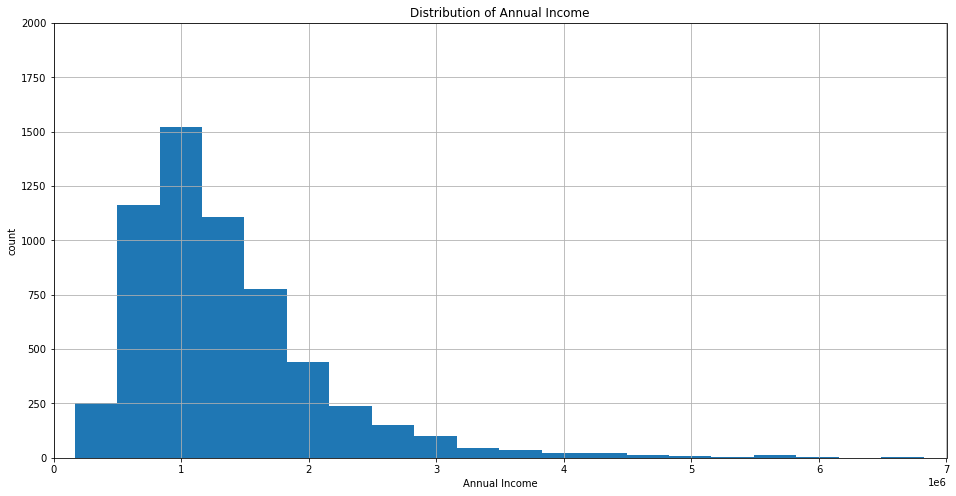

In [24]:
plt.figure(figsize = (16, 8))
plt.axis([0, 7000000, 0, 2000])

df_train['Annual Income'].hist(density=False, bins=30)
plt.ylabel('count')
plt.xlabel('Annual Income')

plt.title('Distribution of Annual Income')
plt.show()

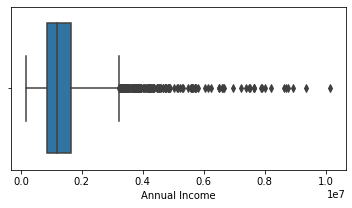

In [25]:
plt.figure(figsize=(6, 3))

sns.boxplot(df_train['Annual Income'], whis=2)

plt.xlabel('Annual Income')
plt.show()

Максимальное значение больше 10 000 000, а минимальное значение меньше 165 000. 

По boxplot, примем, что значения > 3 500 0000 выбросы.

Возьмем квантиль для мин и макс значений:

In [26]:
df_train['Annual Income'].quantile(.975), df_train['Annual Income'].quantile(.025)

(3444213.5999999996, 447499.4)

In [27]:
Annual_Income_max_value = df_train['Annual Income'].quantile(.975)
Annual_Income_max_value

3444213.5999999996

In [28]:
Annual_Income_min_value = df_train['Annual Income'].quantile(.025)
Annual_Income_min_value

447499.4

Посчитаем, что значения меньше quantile(.025), тоже являются выбросами.

In [29]:
df_train['Annual Income_outlier'] = 0

In [30]:
 conditionAI = ((df_train['Annual Income'] > Annual_Income_max_value) | (df_train['Annual Income'] < Annual_Income_min_value))

In [31]:
df_train.loc[conditionAI, 'Annual Income_outlier'] = 1

In [32]:
 df_train.loc[conditionAI, 'Annual Income'] = df_train['Annual Income'].median()

**Tax Liens**

In [33]:
df_train['Tax Liens'].describe()

count    7500.000000
mean        0.030133
std         0.271604
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         7.000000
Name: Tax Liens, dtype: float64

In [34]:
df_train['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64

В Test есть значения 15.0, которого нет в Train. Значений больше 2.0 не много, заменим их на mode()

In [35]:
df_train['Tax Liens_outlier'] = 0

In [36]:
df_train.loc[(df_train['Tax Liens'] > 2), 'Tax Liens_outlier'] = 1

In [37]:
df_train.loc[(df_train['Tax Liens'] > 2), 'Tax Liens'] = df_train['Tax Liens'].mode()[0]

In [38]:
df_train['Tax Liens'] = df_train['Tax Liens'].astype(str)

#### Number of Open Accounts

In [39]:
df_train['Number of Open Accounts'].describe()

count    7500.000000
mean       11.130933
std         4.908924
min         2.000000
25%         8.000000
50%        10.000000
75%        14.000000
max        43.000000
Name: Number of Open Accounts, dtype: float64

In [40]:
df_train['Number of Open Accounts'].value_counts(ascending=False)

9.0     728
11.0    692
10.0    677
8.0     638
7.0     613
12.0    562
6.0     504
13.0    465
14.0    420
5.0     325
15.0    313
16.0    265
17.0    232
4.0     212
18.0    143
19.0    139
3.0      95
20.0     93
21.0     78
23.0     59
24.0     50
22.0     49
25.0     32
2.0      28
28.0     14
27.0     14
26.0     12
30.0     11
29.0     10
33.0      6
31.0      6
32.0      6
34.0      2
37.0      2
42.0      1
43.0      1
35.0      1
38.0      1
41.0      1
Name: Number of Open Accounts, dtype: int64

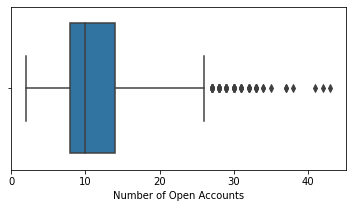

In [41]:
plt.figure(figsize=(6, 3))

sns.boxplot(df_train['Number of Open Accounts'], whis=2)

plt.xlabel('Number of Open Accounts')
plt.show()

По boxplot, примем все, что больше 26, за выбросы, а также посчитаем квантиль.

In [42]:
df_train['Number of Open Accounts'].quantile(.975), df_train['Number of Open Accounts'].quantile(.025)

(23.0, 4.0)

In [43]:
df_train.loc[df_train['Number of Open Accounts'] > 26]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Home Ownership_outlier,Annual Income_outlier,Tax Liens_outlier
305,Rent,NaN,< 1 year,0.0,32.0,9.0,96668.0,0.0,75.0,0.0,other,Short Term,75262.0,47424.0,1870.0,NaN,0,0,0,0
342,Home Mortgage,NaN,6 years,0.0,33.0,15.5,2369664.0,0.0,15.0,0.0,debt consolidation,Long Term,482702.0,648755.0,15379.0,NaN,0,0,0,0
423,Home Mortgage,1277161.0,NaN,0.0,32.0,15.4,392722.0,0.0,NaN,0.0,home improvements,Short Term,259072.0,31882.0,10164.0,750.0,0,0,0,0
464,Rent,1246248.0,10+ years,0.0,31.0,18.4,2366496.0,0.0,NaN,0.0,debt consolidation,Short Term,333014.0,772559.0,22744.0,748.0,0,0,0,0
658,Home Mortgage,2031708.0,1 year,0.0,30.0,16.7,2925120.0,0.0,NaN,0.0,debt consolidation,Short Term,784168.0,714932.0,26920.0,709.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6926,Rent,1269124.0,10+ years,0.0,30.0,17.8,1084666.0,1.0,50.0,1.0,debt consolidation,Short Term,225830.0,430901.0,35536.0,695.0,1,0,0,0
7089,Rent,1168386.0,7 years,0.0,27.0,27.2,3930212.0,0.0,NaN,0.0,debt consolidation,Short Term,664642.0,967366.0,57593.0,742.0,0,0,1,0
7156,Own Home,NaN,4 years,0.0,28.0,23.6,1136916.0,0.0,NaN,0.0,debt consolidation,Long Term,371822.0,660801.0,26638.0,NaN,1,0,0,0
7292,Home Mortgage,1414892.0,8 years,0.0,28.0,15.2,1240426.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,325660.0,33839.0,738.0,0,0,0,0


In [44]:
df_train['Number of Open Accounts_outlier'] = 0

In [45]:
df_train.loc[df_train['Number of Open Accounts'] > 26, 'Number of Open Accounts_outlier'] = 1

In [46]:
df_train.loc[df_train['Number of Open Accounts'] > 26, 'Number of Open Accounts'] = df_train['Number of Open Accounts'].median()

#### Years of Credit History

In [47]:
df_train['Years of Credit History'].describe()

count    7500.000000
mean       18.317467
std         7.041946
min         4.000000
25%        13.500000
50%        17.000000
75%        21.800000
max        57.700000
Name: Years of Credit History, dtype: float64

In [48]:
df_train['Years of Credit History'].value_counts(ascending=False)

15.0    104
16.0     99
16.5     91
17.0     86
17.5     83
       ... 
43.5      1
50.0      1
40.1      1
51.5      1
41.6      1
Name: Years of Credit History, Length: 408, dtype: int64

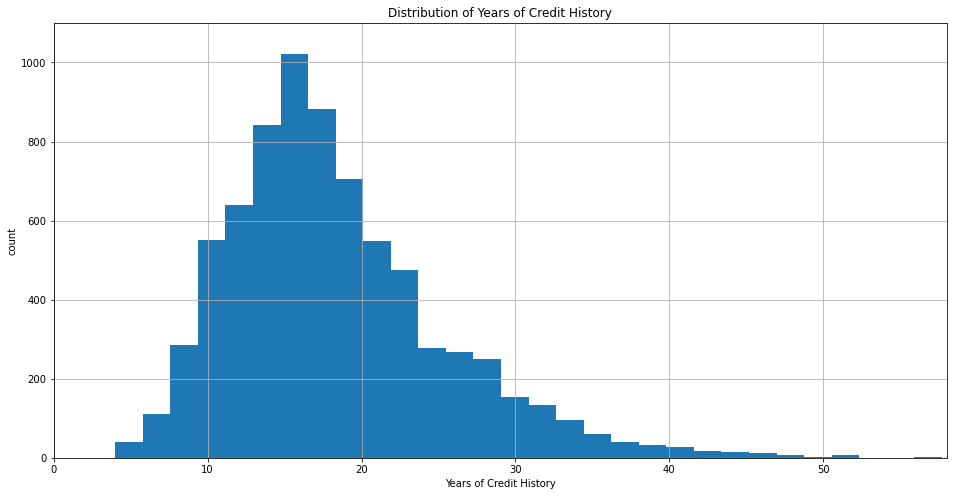

In [49]:
plt.figure(figsize = (16, 8))
plt.axis([0, 58, 0, 1100])

df_train['Years of Credit History'].hist(density=False, bins=30)
plt.ylabel('count')
plt.xlabel('Years of Credit History')

plt.title('Distribution of Years of Credit History')
plt.show()

In [50]:
df_train['Years of Credit History'].quantile(.975), df_train['Years of Credit History'].quantile(.025)

(35.2, 8.0)

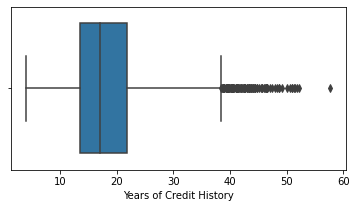

In [51]:
plt.figure(figsize=(6, 3))

sns.boxplot(df_train['Years of Credit History'], whis=2)

plt.xlabel('Years of Credit History')
plt.show()

За выбросы примем значения больше quantile(.975).

In [52]:
df_train['Years of Credit History_outlier'] = 0

In [53]:
df_train.loc[df_train['Years of Credit History'] > 35.2, 'Years of Credit History_outlier'] = 1

In [54]:
df_train.loc[df_train['Years of Credit History'] > 35.2, 'Years of Credit History'] = df_train['Years of Credit History'].median()

#### Maximum Open Credit

In [55]:
df_train['Maximum Open Credit'].describe()

count    7.500000e+03
mean     9.451537e+05
std      1.602622e+07
min      0.000000e+00
25%      2.792295e+05
50%      4.781590e+05
75%      7.935015e+05
max      1.304726e+09
Name: Maximum Open Credit, dtype: float64

In [56]:
df_train['Maximum Open Credit'].value_counts(ascending=False)

0.0          65
319110.0      5
334796.0      3
358732.0      3
323312.0      3
             ..
235642.0      1
1435456.0     1
397078.0      1
537680.0      1
1516482.0     1
Name: Maximum Open Credit, Length: 6963, dtype: int64

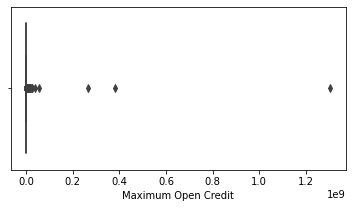

In [57]:
plt.figure(figsize=(6, 3))

sns.boxplot(df_train['Maximum Open Credit'], whis=2)

plt.xlabel('Maximum Open Credit')
plt.show()

В колонке 'Maximum Open Credit' есть значения, превышающие 100 000 000, что скорее всего является выбросом. Воспользуемся quantile, что бы их исключить.

Кватиль макс показывает высокие значения, т.к. есть очень большие значения и они накладывают сой отпечаток.

В модели финальной, при уменьшении макс значений Maximum Open Credit, результат показывает на 0.03 меньше на Test, чем при высоких значениях.

In [58]:
df_train['Maximum Open Credit'].quantile(.975), df_train['Maximum Open Credit'].quantile(.025)

(2236204.2999999984, 70912.60000000002)

In [59]:
Maximum_Open_Credit_max_value = np.quantile(df_train['Maximum Open Credit'], q=0.975)

In [60]:
Maximum_Open_Credit_max_value

2236204.2999999984

In [61]:
Maximum_Open_Credit_min_value = np.quantile(df_train['Maximum Open Credit'], q=0.025)

In [62]:
Maximum_Open_Credit_min_value

70912.60000000002

In [63]:
df_train['Maximum Open Credit_outlier'] = 0

In [64]:
conditionMOC = ((df_train['Maximum Open Credit'] > Maximum_Open_Credit_max_value) | (df_train['Maximum Open Credit'] < Maximum_Open_Credit_min_value))

In [65]:
df_train.loc[conditionMOC, 'Maximum Open Credit_outlier'] = 1

In [66]:
df_train.loc[conditionMOC, 'Maximum Open Credit'] = df_train['Maximum Open Credit'].median()

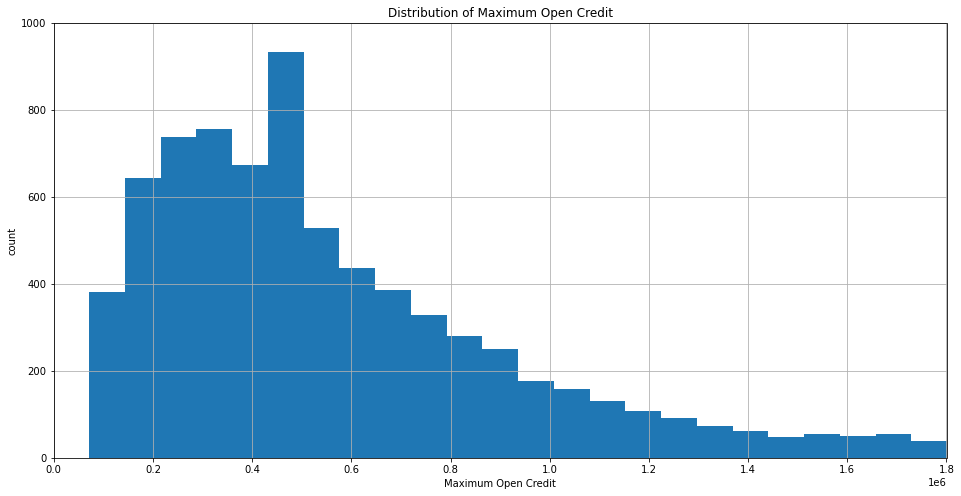

In [67]:
plt.figure(figsize = (16, 8))
plt.axis([0, 1800000, 0, 1000])

df_train['Maximum Open Credit'].hist(density=False, bins=30)
plt.ylabel('count')
plt.xlabel('Maximum Open Credit')

plt.title('Distribution of Maximum Open Credit')
plt.show()

### Number of Credit Problems

In [68]:
df_train['Number of Credit Problems'].describe()

count    7500.000000
mean        0.170000
std         0.498598
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         7.000000
Name: Number of Credit Problems, dtype: float64

In [69]:
df_train['Number of Credit Problems'].value_counts(ascending=False)

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

#### Current Loan Amount

In [70]:
df_train['Current Loan Amount'].describe()

count    7.500000e+03
mean     1.187318e+07
std      3.192612e+07
min      1.124200e+04
25%      1.801690e+05
50%      3.095730e+05
75%      5.198820e+05
max      1.000000e+08
Name: Current Loan Amount, dtype: float64

In [71]:
df_train['Current Loan Amount'].value_counts(ascending=False)

99999999.0    870
218064.0        6
89298.0         6
216106.0        5
265826.0        5
             ... 
104324.0        1
201080.0        1
427812.0        1
665544.0        1
191136.0        1
Name: Current Loan Amount, Length: 5386, dtype: int64

Обработаем 870 значений равных 99999999, явно являющихся выбросами.

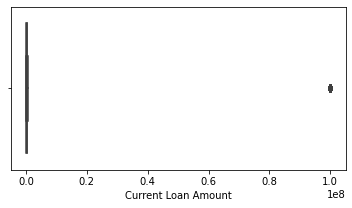

In [72]:
plt.figure(figsize=(6, 3))

sns.boxplot(df_train['Current Loan Amount'], whis=2)

plt.xlabel('Current Loan Amount')
plt.show()

In [73]:
df_train['Current Loan Amount'].quantile(.975), df_train['Current Loan Amount'].quantile(.025)

(99999999.0, 57750.55000000001)

In [74]:
df_train['Current Loan Amount_outlier'] = 0

In [75]:
df_train.loc[df_train['Current Loan Amount'] > 800000, 'Current Loan Amount_outlier'] = 1

In [76]:
df_train.loc[df_train['Current Loan Amount'] > 800000, 'Current Loan Amount'] = df_train['Current Loan Amount'].median()

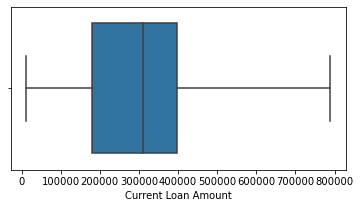

In [77]:
plt.figure(figsize=(6, 3))

sns.boxplot(df_train['Current Loan Amount'], whis=2)

plt.xlabel('Current Loan Amount')
plt.show()

Также присутствуют значения 'Monthly Debt' > 'Current Loan Amount', что является выбросом, так как долг не может быть больше текущей суммы кредита.

In [78]:
df_train.loc[df_train['Monthly Debt'] > df_train['Current Loan Amount']]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Monthly Debt,Credit Score,Credit Default,Home Ownership_outlier,Annual Income_outlier,Tax Liens_outlier,Number of Open Accounts_outlier,Years of Credit History_outlier,Maximum Open Credit_outlier,Current Loan Amount_outlier
44,Home Mortgage,1334256.0,10+ years,0.0,17.0,15.4,478159.0,1.0,35.0,0.0,...,34357.0,729.0,0,1,0,0,0,0,1,0
548,Home Mortgage,NaN,10+ years,0.0,18.0,14.1,1348556.0,0.0,NaN,0.0,...,66848.0,NaN,0,0,0,0,0,0,0,0
2688,Home Mortgage,1822423.0,8 years,0.0,8.0,24.6,972224.0,0.0,46.0,0.0,...,41764.0,714.0,0,0,0,0,0,0,0,0
2721,Rent,3120180.0,10+ years,0.0,24.0,21.5,1024584.0,0.0,24.0,0.0,...,41863.0,705.0,0,0,0,0,0,0,0,0
4863,Home Mortgage,1381110.0,6 years,0.0,19.0,21.3,618464.0,0.0,NaN,0.0,...,26966.0,719.0,1,0,0,0,0,0,0,0
5317,Home Mortgage,980685.0,10+ years,0.0,12.0,17.0,260392.0,2.0,40.0,1.0,...,24109.0,721.0,0,1,0,0,0,1,0,0


In [79]:
conditionMD = (df_train['Monthly Debt'] > df_train['Current Loan Amount'])

In [80]:
df_train.loc[conditionMD, 'Current Loan Amount_outlier'] = 1

In [81]:
df_train.loc[conditionMD, 'Current Loan Amount'] = df_train.loc[conditionMD, 'Monthly Debt']

#### Current Credit Balance	

(сколько выплатил)

In [82]:
df_train['Current Credit Balance'].describe()

count    7.500000e+03
mean     2.898332e+05
std      3.178714e+05
min      0.000000e+00
25%      1.142565e+05
50%      2.093230e+05
75%      3.604062e+05
max      6.506797e+06
Name: Current Credit Balance, dtype: float64

In [83]:
df_train['Current Credit Balance'].value_counts(ascending=False)

0.0         53
191710.0     5
106818.0     4
136401.0     4
82289.0      4
            ..
64733.0      1
66709.0      1
42199.0      1
871036.0     1
346902.0     1
Name: Current Credit Balance, Length: 6592, dtype: int64

In [84]:
df_train['Current Credit Balance'].quantile(.975), df_train['Current Credit Balance'].quantile(.025)

(1001579.7749999975, 11970.0)

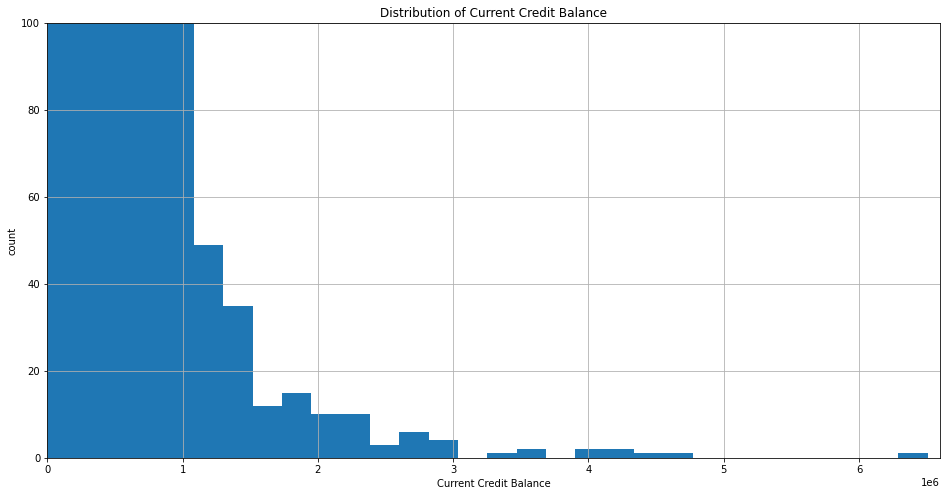

In [85]:
plt.figure(figsize = (16, 8))
plt.axis([0, 6600000, 0, 100])

df_train['Current Credit Balance'].hist(density=False, bins=30)
plt.ylabel('count')
plt.xlabel('Current Credit Balance')

plt.title('Distribution of Current Credit Balance')
plt.show()

За выбросы примем значения < quantile(.025).

In [86]:
Current_Credit_Balance_min_value = np.quantile(df_train['Current Credit Balance'], q=0.025)
Current_Credit_Balance_min_value

11970.0

In [87]:
df_train['Current Credit Balance_outlier'] = 0

In [88]:
conditionCCB = ((df_train['Current Credit Balance'] < Current_Credit_Balance_min_value))

In [89]:
df_train.loc[conditionCCB, 'Current Credit Balance_outlier'] = 1

In [90]:
df_train.loc[conditionCCB, 'Current Credit Balance'] = df_train['Current Credit Balance'].median()

Также присутствуют значения 'Monthly Debt' > 'Current Credit Balance', что является выбросом, так как долг не может быть больше выплаченной суммы кредита, либо была просрочка.

In [91]:
conditionCCB_2 = (df_train['Current Credit Balance'] < df_train['Monthly Debt'])


In [92]:
df_train.loc[conditionCCB_2, 'Current Credit Balance_outlier'] = 1

In [93]:
df_train.loc[conditionCCB_2, 'Current Credit Balance'] = df_train['Current Credit Balance'].median()

#### Monthly Debt

In [94]:
df_train['Monthly Debt'].describe()

count      7500.000000
mean      18314.454133
std       11926.764673
min           0.000000
25%       10067.500000
50%       16076.500000
75%       23818.000000
max      136679.000000
Name: Monthly Debt, dtype: float64

In [95]:
df_train['Monthly Debt'].value_counts(ascending=False)

0.0        6
19667.0    4
19222.0    4
19277.0    3
9669.0     3
          ..
12857.0    1
10777.0    1
29267.0    1
25050.0    1
31119.0    1
Name: Monthly Debt, Length: 6716, dtype: int64

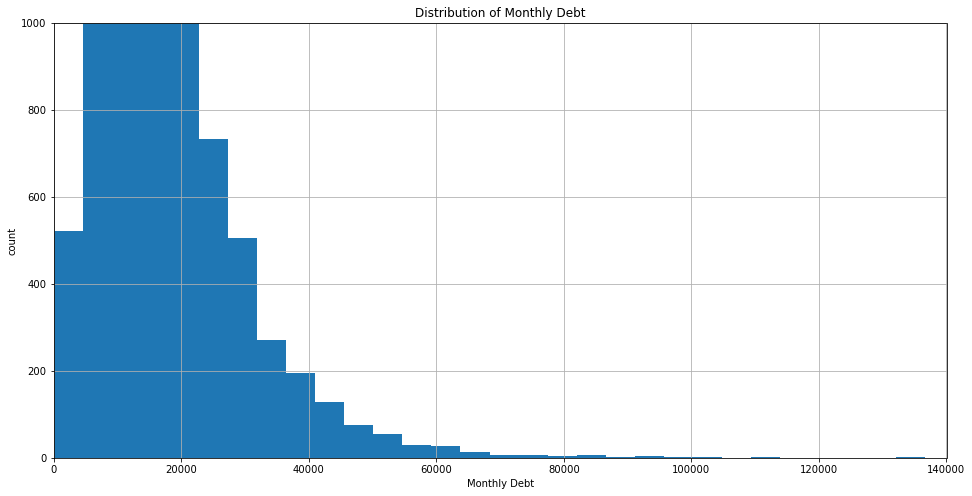

In [96]:
plt.figure(figsize = (16, 8))
plt.axis([0, 140000, 0, 1000])

df_train['Monthly Debt'].hist(density=False, bins=30)
plt.ylabel('count')
plt.xlabel('Monthly Debt')

plt.title('Distribution of Monthly Debt')
plt.show()

In [97]:
df_train['Monthly Debt'].quantile(.975), df_train['Monthly Debt'].quantile(.025)

(47950.149999999965, 2433.95)

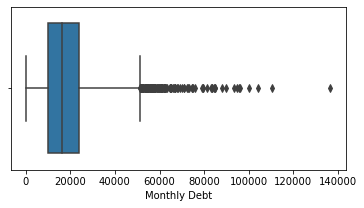

In [98]:
plt.figure(figsize=(6, 3))

sns.boxplot(df_train['Monthly Debt'], whis=2)

plt.xlabel('Monthly Debt')
plt.show()

Примем за выбросы значения 0 (Monthly Debt не может быть больше 0), и значения больше quantile(.975).

In [99]:
Monthly_Debt_max_value = np.quantile(df_train['Monthly Debt'], q=0.975)

In [100]:
Monthly_Debt_min_value = np.quantile(df_train['Monthly Debt'], q=0.025)

In [101]:
df_train['Monthly Debt_outlier'] = 0

In [102]:
conditionMD = ((df_train['Monthly Debt'] > Monthly_Debt_max_value) | (df_train['Monthly Debt'] < Monthly_Debt_min_value))

In [103]:
df_train.loc[conditionMD, 'Monthly Debt_outlier'] = 1

In [104]:
df_train.loc[conditionMD, 'Monthly Debt'] = df_train['Monthly Debt'].median()

#### Credit Score

In [105]:
df_train['Credit Score'].describe()

count    5943.000000
mean     1151.087498
std      1604.451418
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64

In [106]:
df_train['Credit Score'].value_counts(ascending=False)

740.0     169
747.0     168
748.0     157
745.0     152
742.0     151
         ... 
629.0       1
606.0       1
6830.0      1
6670.0      1
620.0       1
Name: Credit Score, Length: 268, dtype: int64

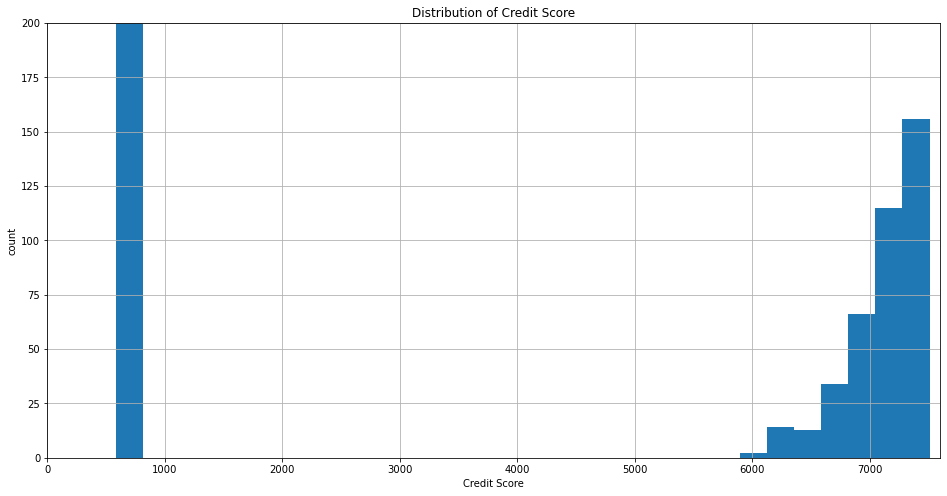

In [107]:
plt.figure(figsize = (16, 8))
plt.axis([0, 7600, 0, 200])

df_train['Credit Score'].hist(density=False, bins=30)
plt.ylabel('count')
plt.xlabel('Credit Score')

plt.title('Distribution of Credit Score')
plt.show()

In [108]:
df_train['Credit Score'].unique()

array([ 749.,  737.,  742.,  694.,  719.,   nan,  745.,  705.,  706.,
        728.,  748.,  727.,  644.,  695.,  712.,  697.,  738.,  720.,
        734.,  740.,  708.,  726.,  722.,  750.,  670.,  721.,  729.,
        723.,  716.,  744.,  707.,  739.,  714.,  701.,  735.,  741.,
        747.,  743., 6470.,  725.,  718.,  674.,  746.,  704., 7440.,
        673.,  653., 7010., 7320.,  751.,  711.,  617.,  730.,  724.,
        624.,  736., 7390.,  667.,  679.,  732.,  693.,  668.,  731.,
       7140., 7470.,  661.,  709.,  717.,  678.,  675.,  700.,  645.,
        683., 7370.,  733., 7040.,  703.,  660.,  715.,  654., 7430.,
        662.,  687.,  710.,  664.,  688.,  698.,  702., 6940.,  643.,
        659.,  666., 7170.,  681.,  692., 7300.,  713.,  627., 7500.,
        689., 6790.,  696.,  699.,  672.,  671., 7310.,  651.,  685.,
        639., 7450., 7100.,  669.,  634.,  658.,  665., 7250.,  642.,
        585., 7350., 7220.,  691., 7460., 7060.,  682.,  593.,  686.,
       6110.,  648.,

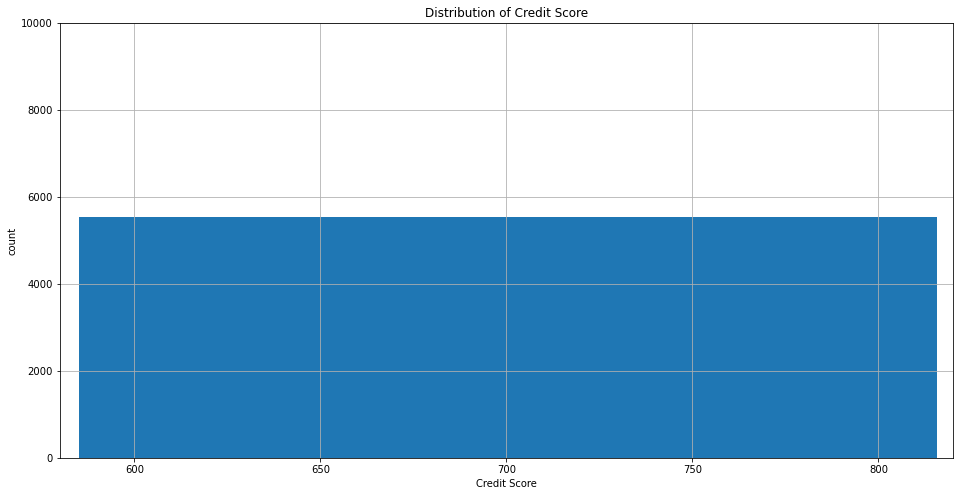

In [109]:
plt.figure(figsize = (16, 8))
plt.axis([580, 820, 0, 10000])

df_train['Credit Score'].hist(density=False, bins=30)
plt.ylabel('count')
plt.xlabel('Credit Score')

plt.title('Distribution of Credit Score')
plt.show()

По данным видно, что есть четырехзначные числа заканчивающиеся на 0, что явно опечатка в данных. Поделим такие данные на 10.

In [110]:
conditionCS = (df_train['Credit Score'] > 820)

In [111]:
df_train.loc[conditionCS, 'Credit Score'] = df_train.loc[conditionCS, 'Credit Score'] / 10

#### Bankruptcies

In [112]:
df_train['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
nan      14
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

Присутствует выброс - значение 'nan'.

Также заменим значения 'Bankruptcies' > 2 на mode.

In [113]:
df_train['Bankruptcies'] = df_train['Bankruptcies'].astype(float)

Проверим, есть ли значения 'nan' в других колонках.

In [114]:
for colname in ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Bankruptcies', 'Purpose', 'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'Credit Default']:
       print(df_train.loc[df_train[colname] == 'nan'])

Empty DataFrame
Columns: [Home Ownership, Annual Income, Years in current job, Tax Liens, Number of Open Accounts, Years of Credit History, Maximum Open Credit, Number of Credit Problems, Months since last delinquent, Bankruptcies, Purpose, Term, Current Loan Amount, Current Credit Balance, Monthly Debt, Credit Score, Credit Default, Home Ownership_outlier, Annual Income_outlier, Tax Liens_outlier, Number of Open Accounts_outlier, Years of Credit History_outlier, Maximum Open Credit_outlier, Current Loan Amount_outlier, Current Credit Balance_outlier, Monthly Debt_outlier]
Index: []

[0 rows x 26 columns]
Empty DataFrame
Columns: [Home Ownership, Annual Income, Years in current job, Tax Liens, Number of Open Accounts, Years of Credit History, Maximum Open Credit, Number of Credit Problems, Months since last delinquent, Bankruptcies, Purpose, Term, Current Loan Amount, Current Credit Balance, Monthly Debt, Credit Score, Credit Default, Home Ownership_outlier, Annual Income_outlier, Tax 

In [115]:
df_train['Bankruptcies_outlier'] = 0

In [116]:
df_train.loc[(df_train['Bankruptcies'] > 2), 'Bankruptcies_outlier'] = 1

In [117]:
df_train.loc[(df_train['Bankruptcies'] > 2), 'Bankruptcies'] = df_train['Bankruptcies'].mode()[0]

In [118]:
df_train['Bankruptcies'] = df_train['Bankruptcies'].astype(str)

In [119]:
df_train['Bankruptcies_nan'] = 0

In [120]:
df_train.loc[(df_train['Bankruptcies'] == 'nan'), 'Bankruptcies_outlier'] = 1

In [121]:
mode = df_train['Bankruptcies'].mode()[0]

In [122]:
df_train.loc[(df_train['Bankruptcies'] == 'nan'), 'Bankruptcies'] = mode

### Обработка пропусков

In [123]:
df_train.isna().sum()

Home Ownership                        0
Annual Income                      1557
Years in current job                371
Tax Liens                             0
Number of Open Accounts               0
Years of Credit History               0
Maximum Open Credit                   0
Number of Credit Problems             0
Months since last delinquent       4081
Bankruptcies                          0
Purpose                               0
Term                                  0
Current Loan Amount                   0
Current Credit Balance                0
Monthly Debt                          0
Credit Score                       1557
Credit Default                        0
Home Ownership_outlier                0
Annual Income_outlier                 0
Tax Liens_outlier                     0
Number of Open Accounts_outlier       0
Years of Credit History_outlier       0
Maximum Open Credit_outlier           0
Current Loan Amount_outlier           0
Current Credit Balance_outlier        0


#### Annual Income

Заменим пропущенные значения на median.

In [124]:
df_train['Annual Income_nan'] = 0

In [125]:
df_train.loc[(df_train['Annual Income'].isna()), 'Annual Income_nan'] = 1

In [126]:
median = df_train['Annual Income'].median()

In [127]:
median

1168386.0

In [128]:
df_train['Annual Income'] = df_train['Annual Income'].fillna(median)

In [129]:
df_train['Annual Income'].isna().sum()

0

#### Years in current job

In [130]:
df_train['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [131]:
df_train['Years in current job_nan'] = 0

In [132]:
df_train.loc[(df_train['Years in current job'].isna()), 'Years in current job_nan'] = 1

In [133]:
df_train['Years in current job_nan'].value_counts()

0    7129
1     371
Name: Years in current job_nan, dtype: int64

Заменим пропущенные значения на mode.

In [134]:
df_train['Years in current job'].mode()[0]

'10+ years'

In [135]:
mode = df_train['Years in current job'].mode()[0]

In [136]:
df_train['Years in current job'].fillna(mode, inplace=True)

In [137]:
df_train['Years in current job'].isna().sum()

0

In [138]:
df_train['Years in current job'].value_counts()

10+ years    2703
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

#### Months since last delinquent

In [139]:
df_train['Months since last delinquent'].isna().sum()

4081

Так как пропущенных значений много, можно колонку 'Months since last delinquent' удалить, но при удалении на Test значения хуже. Удалять не будем.

In [140]:
df_train['Months since last delinquent_nan'] = 0

In [141]:
df_train.loc[(df_train['Months since last delinquent'].isna()), 'Months since last delinquent_nan'] = 1

In [142]:
df_train['Months since last delinquent'].fillna(df_train['Months since last delinquent'].median(), inplace=True)

In [143]:
#df_train.drop('Months since last delinquent', axis=1, inplace=True)

#### Credit Score

In [144]:
df_train['Credit Score'].isna().sum()

1557

Заменим значения на median.

In [145]:
df_train['Credit Score_nan'] = 0

In [146]:
df_train.loc[(df_train['Credit Score'].isna()), 'Credit Score_nan'] = 1

In [147]:
df_train['Credit Score_nan'].value_counts()

0    5943
1    1557
Name: Credit Score_nan, dtype: int64

In [148]:
median = df_train['Credit Score'].median()

In [149]:
median

729.0

In [150]:
df_train['Credit Score'] = df_train['Credit Score'].fillna(median)

In [151]:
df_train['Credit Score'].isna().sum()

0

In [152]:
df_train.isna().sum()

Home Ownership                      0
Annual Income                       0
Years in current job                0
Tax Liens                           0
Number of Open Accounts             0
Years of Credit History             0
Maximum Open Credit                 0
Number of Credit Problems           0
Months since last delinquent        0
Bankruptcies                        0
Purpose                             0
Term                                0
Current Loan Amount                 0
Current Credit Balance              0
Monthly Debt                        0
Credit Score                        0
Credit Default                      0
Home Ownership_outlier              0
Annual Income_outlier               0
Tax Liens_outlier                   0
Number of Open Accounts_outlier     0
Years of Credit History_outlier     0
Maximum Open Credit_outlier         0
Current Loan Amount_outlier         0
Current Credit Balance_outlier      0
Monthly Debt_outlier                0
Bankruptcies

### Построение новых признаков

**ID**

In [153]:
df_train['ID'] = df_train.index.tolist()

**Dummies**


In [154]:
for cat_colname in df_train.select_dtypes(include='object').columns[1:]:
    df_train = pd.concat([df_train, pd.get_dummies(df_train[cat_colname], prefix=cat_colname)], axis=1)

**years_cat**

Разделим 'Years of Credit History' на 5 значений.

In [155]:
def years_to_cat(X):
    bins = [0, 5, 10, 15, 20, X['Years of Credit History'].max()]
    X['years_cat'] = pd.cut(X['Years of Credit History'], bins=bins, labels=False)
    
    X['years_cat'].fillna(-1, inplace=True)
    return X

In [156]:
df_train = years_to_cat(df_train)

**num_cat**

Разделим 'Number of Open Accounts' на 5 значений.

In [157]:
def num_to_cat(X):
    bins = [0, 5, 10, 15, 20, X['Number of Open Accounts'].max()]
    X['num_cat'] = pd.cut(X['Number of Open Accounts'], bins=bins, labels=False)
    
    X['num_cat'].fillna(-1, inplace=True)
    return X

In [158]:
df_train = num_to_cat(df_train)

**credit_cat**

Разделим 'Credit Score' на 5 значений.

In [159]:
def credit_score_to_cat(X):
    bins = [0, 500, 600, 650, 690, X['Credit Score'].max()]
    X['credit_cat'] = pd.cut(X['Credit Score'], bins=bins, labels=False)
    
    X['credit_cat'].fillna(-1, inplace=True)
    return X

In [160]:
df_train = credit_score_to_cat(df_train)

#### Credit score

Наблюдаем значимую связь между целевой переменной и 'Credit Score'.

ПОстроим различные зависимости и выберем какая работает лучше.

**CreditScoreTLB1**

In [161]:
Credit_Score_TLB1 = df_train.groupby(['Number of Open Accounts'], as_index=False).agg({'Credit Score':'mean'}).\
                                            rename(columns={'Credit Score':'CreditScoreTLB1'})

In [162]:
df_train = df_train.merge(Credit_Score_TLB1, on=['Number of Open Accounts'], how='left')

**CreditScoreTLB2**

In [163]:
Credit_Score_TLB2 = df_train.groupby(['Months since last delinquent'], as_index=False).agg({'Credit Score':'mean'}).\
                                            rename(columns={'Credit Score':'CreditScoreTLB2'})

In [164]:
df_train = df_train.merge(Credit_Score_TLB2, on=['Months since last delinquent'], how='left')

**CreditScoreTLB3**

In [165]:
Credit_Score_TLB3 = df_train.groupby(['Tax Liens', 'Bankruptcies'], as_index=False).agg({'Credit Score':'mean'}).\
                                            rename(columns={'Credit Score':'CreditScoreTLB3'})

In [166]:
df_train = df_train.merge(Credit_Score_TLB3, on=['Tax Liens', 'Bankruptcies'], how='left')


**CreditScoreTBNT**

In [167]:
Credit_Score_TBNT = df_train.groupby(['Tax Liens', 'Bankruptcies', 'Number of Credit Problems', 'Term'], as_index=False).agg({'Credit Score':'mean'}).\
                                            rename(columns={'Credit Score':'CreditScoreTBNT'})

In [168]:
df_train = df_train.merge(Credit_Score_TBNT, on=['Tax Liens', 'Bankruptcies', 'Number of Credit Problems', 'Term'], how='left')

AnIMoD

Найдем сумму, которая остается на текущие расходы в месяц.

In [169]:
df_train['AnIMoD'] = (df_train['Annual Income'] / 12) - df_train['Monthly Debt']

**Создадим класс DataPreprocessing и внесем все преобразования, полученные ранее**

In [170]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.means = None
        self.modes = None
        self.Annual_Income_max_value = None
        self.Annual_Income_min_value = None
        self.Maximum_Open_Credit_max_value = None
        self.Maximum_Open_Credit_min_value = None   
        self.Current_Credit_Balance_min_value = None
        self.Monthly_Debt_max_value = None
        self.Monthly_Debt_min_value = None
        self.mode_1 = None
        self.mode_2 = None
        self.mode_3 = None
        self.mode_4 = None
        self.mode_5 = None
        self.mode_6 = None
        self.mode_7 = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.means = X.mean()
        self.modes = X.mode()
        self.Annual_Income_max_value = X['Annual Income'].quantile(.975)
        self.Annual_Income_min_value = X['Annual Income'].quantile(.025)
        self.Maximum_Open_Credit_max_value = X['Maximum Open Credit'].quantile(.975)
        self.Maximum_Open_Credit_min_value = X['Maximum Open Credit'].quantile(.025)
        self.Current_Credit_Balance_min_value = X['Current Credit Balance'].quantile(.025)
        self.Monthly_Debt_max_value = X['Monthly Debt'].quantile(.975)
        self.Monthly_Debt_min_value = X['Monthly Debt'].quantile(.025)
        self.mode_1 = X['Years in current job'].mode()[0]
        self.mode_2 = X['Bankruptcies'].mode()[0]
        self.mode_3 = X['Home Ownership'].mode()[0]
        self.mode_4 = X['Bankruptcies'].mode()[0]
        self.mode_5 = X['Tax Liens'].mode()[0]
        self.mode_6 = X['Purpose'].mode()[0]
        self.mode_7 = X['Number of Credit Problems'].mode()[0]
        
    def transform(self, X):
        """Трансформация данных"""
               
        # Home Ownership
        X['Home Ownership_outlier'] = 0
        X.loc[X['Home Ownership'] == 'Have Mortgage', 'Home Ownership_outlier'] = 1
        X['Home Ownership'].replace({'Have Mortgage': self.mode_3}, inplace=True)
        
        # Annual Income
        X['Annual Income_outlier'] = 0
        conditionAI = ((X['Annual Income'] > self.Annual_Income_max_value) | (X['Annual Income'] < self.Annual_Income_min_value))
        X.loc[conditionAI, 'Annual Income_outlier'] = 1
        X.loc[conditionAI, 'Annual Income'] = self.medians['Annual Income']
        X['Annual Income_nan'] = 0
        X.loc[(X['Annual Income'].isna()), 'Annual Income_nan'] = 1
        X['Annual Income'].fillna(self.medians, inplace=True)
        
        # Tax Liens
        X['Tax Liens_outlier'] = 0        
        X.loc[(X['Tax Liens'] > 2), 'Tax Liens_outlier'] = 1
        X.loc[(X['Tax Liens'] > 2), 'Tax Liens'] = self.mode_5
        X['Tax Liens'] = X['Tax Liens'].astype(str)
        
        # Number of Open Accounts
        X['Number of Open Accounts_outlier'] = 0
        X.loc[X['Number of Open Accounts'] > 26, 'Number of Open Accounts_outlier'] = 1
        X.loc[X['Number of Open Accounts'] > 26, 'Number of Open Accounts'] = self.medians['Number of Open Accounts']
        
        # Months since last delinquent
        X['Months since last delinquent_nan'] = 0
        X.loc[(X['Months since last delinquent'].isna()), 'Months since last delinquent_nan'] = 1
        X['Months since last delinquent'].fillna(self.medians, inplace=True)
        
        # Bankruptcies
        X['Bankruptcies_outlier'] = 0
        X.loc[(X['Bankruptcies'] > 2), 'Bankruptcies_outlier'] = 1
        X.loc[(X['Bankruptcies'] > 2), 'Bankruptcies'] = self.mode_4
        
        X['Bankruptcies'] = X['Bankruptcies'].astype(str)
        X['Bankruptcies_nan'] = 0
        X.loc[(X['Bankruptcies'] == 'nan'), 'Bankruptcies_nan'] = 1
        X.replace({'Bankruptcies':{'nan': self.mode_4}}, inplace=True)        
        X['Bankruptcies'] = X['Bankruptcies'].astype(str)
        
        # Purpose
        X['Purpose_nan'] = 0
        X.loc[(X['Purpose'] == 'renewable energy'), 'Purpose_nan'] = 1
        X.replace({'Purpose':{'renewable energy': self.mode_6}}, inplace=True)
        
        # Years of Credit History
        X['Years of Credit History_outlier'] = 0
        X.loc[X['Years of Credit History'] > 35.2, 'Years of Credit History_outlier'] = 1
        X.loc[X['Years of Credit History'] > 35.2, 'Years of Credit History'] = self.medians['Years of Credit History']
        
        # Maximum Open Credit
        X['Maximum Open Credit_outlier'] = 0
        conditionMOC = ((X['Maximum Open Credit'] > self.Maximum_Open_Credit_max_value) | (X['Maximum Open Credit'] < self.Maximum_Open_Credit_min_value))
        X.loc[conditionMOC, 'Maximum Open Credit_outlier'] = 1
        X.loc[conditionMOC, 'Maximum Open Credit'] = self.medians['Maximum Open Credit']
        
                
        # Current Loan Amount
        X['Current Loan Amount_outlier'] = 0
        X.loc[X['Current Loan Amount'] > 800000, 'Current Loan Amount_outlier'] = 1
        X.loc[X['Current Loan Amount'] > 800000, 'Current Loan Amount'] = self.medians['Current Loan Amount']
        conditionMD = (X['Monthly Debt'] > X['Current Loan Amount'])
        X.loc[conditionMD, 'Current Loan Amount_outlier'] = 1
        X.loc[conditionMD, 'Current Loan Amount'] = X.loc[conditionMD, 'Monthly Debt']
        
        # Current Credit Balance
        X['Current Credit Balance_outlier'] = 0
        conditionCCB = ((X['Current Credit Balance'] < self.Current_Credit_Balance_min_value))
        X.loc[conditionCCB, 'Current Credit Balance_outlier'] = 1
        X.loc[conditionCCB, 'Current Credit Balance'] = self.medians['Current Credit Balance']
        conditionCCB_2 = (X['Current Credit Balance'] < X['Monthly Debt'])
        X.loc[conditionCCB_2, 'Current Credit Balance_outlier'] = 1
        X.loc[conditionCCB_2, 'Current Credit Balance'] = self.medians['Current Credit Balance']
        
        # Monthly Debt
        X['Monthly Debt_outlier'] = 0
        conditionMD = ((X['Monthly Debt'] > self.Monthly_Debt_max_value) | (X['Monthly Debt'] < self.Monthly_Debt_min_value))
        X.loc[conditionMD, 'Monthly Debt_outlier'] = 1
        X.loc[conditionMD, 'Monthly Debt'] = self.medians['Monthly Debt']
        
        # Credit Score
        conditionCS = (X['Credit Score'] > 820)
        X.loc[conditionCS, 'Credit Score'] = X.loc[conditionCS, 'Credit Score'] / 10
        X['Credit Score_nan'] = 0
        X.loc[(X['Credit Score'].isna()), 'Credit Score_nan'] = 1
        X['Credit Score'].fillna(self.medians, inplace=True)        
                
        # Years in current job
        X['Years in current job_nan'] = 0
        X.loc[(X['Years in current job'].isna()), 'Years in current job_nan'] = 1
        X['Years in current job'].fillna(self.mode_1, inplace=True)
                
               
        X.fillna(self.medians, inplace=True)
        
        return X

**Создадим класс FeatureGenetator и включим все прежние преобразования в него**

In [171]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.Years_of_Credit_History_max = None
        self.Number_of_Open_Accounts_max = None
        self.Credit_Score_max = None
        self.Credit_Score_TLB1 = None
        self.Credit_Score_TLB2 = None
        self.Credit_Score_TLB3 = None
        self.Credit_Score_TBNT = None
       
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        self.Years_of_Credit_History_max = X['Years of Credit History'].max()
        self.Number_of_Open_Accounts_max = X['Number of Open Accounts'].max()
        self.Credit_Score_max = X['Credit Score'].max()
            
        # CreditScoreTLB1
        self.Credit_Score_TLB1 = X.groupby(['Number of Open Accounts'], as_index=False).agg({'Credit Score':'mean'}).\
                                            rename(columns={'Credit Score':'CreditScoreTLB1'})
        self.Credit_Score_TLB1_mean = self.Credit_Score_TLB1['CreditScoreTLB1'].mean()
        
        # CreditScoreTLB2 
        self.Credit_Score_TLB2 = X.groupby(['Months since last delinquent'], as_index=False).agg({'Credit Score':'mean'}).\
                                            rename(columns={'Credit Score':'CreditScoreTLB2'})
        self.Credit_Score_TLB2_mean = self.Credit_Score_TLB2['CreditScoreTLB2'].mean()
        
        # CreditScoreTLB3
        self.Credit_Score_TLB3 = X.groupby(['Tax Liens', 'Bankruptcies'], as_index=False).agg({'Credit Score':'mean'}).\
                                            rename(columns={'Credit Score':'CreditScoreTLB3'})
        self.Credit_Score_TLB3_mean = self.Credit_Score_TLB3['CreditScoreTLB3'].mean()
        
        # CreditScoreTLB3
        self.Credit_Score_TBNT = X.groupby(['Tax Liens', 'Bankruptcies', 'Number of Credit Problems', 'Term'], as_index=False).agg({'Credit Score':'mean'}).\
                                            rename(columns={'Credit Score':'CreditScoreTBNT'})
        self.Credit_Score_TBNT_mean = self.Credit_Score_TBNT['CreditScoreTBNT'].mean()
      
    def transform(self, X):
                
        
        # dummies
        for cat_colname in X.select_dtypes(include='object').columns[1:]:
            X = pd.concat([X, pd.get_dummies(X[cat_colname], prefix=cat_colname)], axis=1)
        
        X = pd.concat([X, pd.get_dummies(X['Home Ownership'])], axis=1)
        
        # ID
        X['ID'] = X.index.tolist()
        
        X = self.years_to_cat(X)
        X = self.num_to_cat(X)
        X = self.credit_score_to_cat(X)
        
        # Target encoding
        if self.Credit_Score_TLB1 is not None:
            X = X.merge(self.Credit_Score_TLB1, on=['Number of Open Accounts'], how='left')
            X['CreditScoreTLB1'].fillna(self.Credit_Score_TLB1_mean, inplace=True)
        
        # Target encoding 
        if self.Credit_Score_TLB2 is not None:
            X = X.merge(self.Credit_Score_TLB2, on=['Months since last delinquent'], how='left')
            X['CreditScoreTLB2'].fillna(self.Credit_Score_TLB2_mean, inplace=True)
        
        # Target encoding 
        if self.Credit_Score_TLB3 is not None:
            X = X.merge(self.Credit_Score_TLB3, on=['Tax Liens', 'Bankruptcies'], how='left')
            X['CreditScoreTLB3'].fillna(self.Credit_Score_TLB3_mean, inplace=True)
            
        if self.Credit_Score_TBNT is not None:
            X = X.merge(self.Credit_Score_TBNT, on=['Tax Liens', 'Bankruptcies', 'Number of Credit Problems', 'Term'], how='left')
            X['CreditScoreTBNT'].fillna(self.Credit_Score_TBNT_mean, inplace=True)
        
        X['AnIMoD'] = (X['Annual Income'] / 12) - X['Monthly Debt']
        
        return X
        
    def years_to_cat(self, X):
        bins = [0, 5, 10, 15, 20, self.Years_of_Credit_History_max]
        X['years_cat'] = pd.cut(X['Years of Credit History'], bins=bins, labels=False)
    
        X['years_cat'].fillna(-1, inplace=True)
        
        return X
    
    def num_to_cat(self, X):
        bins = [0, 5, 10, 15, 20, self.Number_of_Open_Accounts_max]
        X['num_cat'] = pd.cut(X['Number of Open Accounts'], bins=bins, labels=False)
    
        X['num_cat'].fillna(-1, inplace=True)
        
        return X
    
    def credit_score_to_cat(self, X):
        bins = [0, 500, 600, 650, 690, self.Credit_Score_max]
        X['credit_cat'] = pd.cut(X['Credit Score'], bins=bins, labels=False)
    
        X['credit_cat'].fillna(-1, inplace=True)
        
        return X

Получим с помощью созданных классов обработанные данные для df_train и df_test и запишем их.

In [172]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

In [173]:
data_preprocessor = DataPreprocessing()
data_preprocessor.fit(df_train)

In [174]:
df_train = data_preprocessor.transform(df_train)
df_test = data_preprocessor.transform(df_test)

In [175]:
df_train.shape, df_test.shape

((7500, 33), (2500, 32))

In [176]:
features_gen = FeatureGenetator()
features_gen.fit(df_train)

In [177]:
df_train = features_gen.transform(df_train)
df_test = features_gen.transform(df_test)

In [178]:
df_train.shape, df_test.shape

((7500, 78), (2500, 77))

In [179]:
df_train.isna().sum().sum(), df_test.isna().sum().sum()

(0, 0)

Запишем полученные данные

In [180]:
df_train.to_csv(PREP_TRAIN_DATASET_PATH, index=False, encoding='utf-8')

Загрузим полученные данные

In [181]:
df = pd.read_csv(PREP_TRAIN_DATASET_PATH)

**Выделение целевой переменной и групп признаков**

In [182]:
target_name = 'Credit Default'

feature_names = ['Annual Income', 'Number of Open Accounts', 'Maximum Open Credit', 
                 'Number of Credit Problems', 'Months since last delinquent', 
                 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 
                 'Credit Score']

new_feature_names = ['Home Ownership_outlier',
 'Annual Income_outlier',
 'Annual Income_nan',
 'Tax Liens_outlier',
 'Number of Open Accounts_outlier',
# 'Months since last delinquent_nan',
 'Bankruptcies_outlier',
# 'Bankruptcies_nan',
# 'Purpose_nan',
 'Years of Credit History_outlier',
 'Maximum Open Credit_outlier',
# 'Number of Credit Problems_0.0', 
# 'Number of Credit Problems_1.0',
# 'Number of Credit Problems_2.0',
# 'Number of Credit Problems_3.0',
 'Current Loan Amount_outlier',
 'Current Credit Balance_outlier',
 'Monthly Debt_outlier',
 'Credit Score_nan',
 'Years in current job_nan',
 'Years in current job_1 year',
# 'Years in current job_10+ years',
# 'Years in current job_2 years',
# 'Years in current job_3 years',
# 'Years in current job_4 years',
 'Years in current job_5 years',
# 'Years in current job_6 years',
 'Years in current job_7 years',
# 'Years in current job_8 years',
 'Years in current job_9 years',
# 'Years in current job_< 1 year',
# 'Tax Liens_0.0',
 'Tax Liens_1.0',
 'Tax Liens_2.0',
# 'Tax Liens_3.0',
 'Bankruptcies_0.0',
 'Bankruptcies_1.0',
 'Bankruptcies_2.0',
 'Purpose_business loan',
 'Purpose_buy a car',
 'Purpose_buy house',
 'Purpose_debt consolidation',
 'Purpose_educational expenses',
 'Purpose_home improvements',
 'Purpose_major purchase',
 'Purpose_medical bills',
 'Purpose_moving',
 'Purpose_other',
 'Purpose_small business',
 'Purpose_take a trip',
 'Purpose_vacation',
 'Purpose_wedding',
 'Term_Long Term',
 'Term_Short Term',
 'Home Mortgage',
 'Own Home',
 'Rent', 
 'CreditScoreTLB1', 
 'CreditScoreTBNT', 
 'AnIMoD', 
 'years_cat']
# 'num_cat',
# 'credit_cat'
# 'CreditScoreTLB2'
# 'CreditScoreTLB3'

selected_feature_names = feature_names + new_feature_names

**Приведем df_test в соответствие с полученными признаками selected_feature_names**

In [183]:
df_test = df_test[selected_feature_names]

In [184]:
df_test.shape

(2500, 54)

In [185]:
df_test.isna().sum().sum()

0

**Разбиение на train и test**

In [186]:
X = df[selected_feature_names]
y = df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

In [187]:
df_test

,Annual Income,Number of Open Accounts,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Home Ownership_outlier,...,Purpose_wedding,Term_Long Term,Term_Short Term,Home Mortgage,Own Home,Rent,CreditScoreTLB1,CreditScoreTBNT,AnIMoD,years_cat
0,1168386.0,9.0,220968.0,0.0,70.0,162470.0,105906.0,6813.0,731.0,0,...,0,0,1,0,0,1,722.991758,729.210162,90552.500000,2
1,1168386.0,6.0,478159.0,0.0,8.0,78298.0,46037.0,16076.5,699.0,0,...,0,0,1,0,0,1,724.378968,729.210162,81289.000000,4
2,1152540.0,10.0,204600.0,0.0,32.0,200178.0,146490.0,18729.0,726.0,0,...,0,0,1,1,0,0,720.584329,729.210162,77316.000000,2
3,1220313.0,16.0,456302.0,0.0,70.0,217382.0,213199.0,27559.0,739.0,0,...,0,0,1,1,0,0,723.192453,729.210162,74133.750000,3
4,2340952.0,11.0,1207272.0,0.0,32.0,777634.0,425391.0,42605.0,706.0,0,...,0,1,0,1,0,0,722.420520,704.918523,152474.333333,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1020053.0,14.0,559152.0,1.0,68.0,309573.0,162735.0,15046.0,745.0,0,...,0,0,1,1,0,0,721.302381,725.716287,69958.416667,4
2496,1168386.0,15.0,1737780.0,0.0,77.0,468512.0,1439269.0,32996.0,731.0,0,...,0,0,1,1,0,0,721.699681,729.210162,64369.500000,3
2497,1171806.0,10.0,1706430.0,0.0,32.0,430496.0,676438.0,36912.0,695.0,0,...,0,0,1,1,0,0,720.584329,729.210162,60738.500000,2
2498,723520.0,14.0,945780.0,0.0,32.0,257774.0,391248.0,13506.0,744.0,0,...,0,0,1,0,0,1,721.302381,729.210162,46787.333333,4


**Сохранение обучающего и тестового датасетов**

In [188]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [189]:
df.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
test.to_csv(TEST_PART_PATH, index=False, encoding='utf-8')

**Обучение и оценка финальной модели**

Воспользуемся дисбалансом классов

In [190]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.5496957403651117

In [191]:
final_model = catb.CatBoostClassifier(iterations=39, max_depth=4, 
                                      class_weights=[1, disbalance],
                                      eval_metric='F1',
                                      boosting_type='Plain',
                                      silent=True, 
                                      random_state=21,
                                      score_function='Cosine',
                                      grow_policy='SymmetricTree',
                                      #min_data_in_leaf=25, grow_policy='Lossguide', iterations=25, max_depth=5 (TRAIN 0.54, TEST 0.528)                                      
                                      early_stopping_rounds=9)

final_model.fit(X_train, y_train, eval_set=(X_test, y_test))

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

evaluate_preds1(final_model, X_train, X_test, y_train, y_test)

TRAIN
 0.535
TEST
 0.529
TRAIN

              precision    recall  f1-score   support

           0       0.86      0.59      0.70      3771
           1       0.42      0.74      0.53      1479

    accuracy                           0.64      5250
   macro avg       0.64      0.67      0.62      5250
weighted avg       0.73      0.64      0.65      5250

TEST

              precision    recall  f1-score   support

           0       0.86      0.57      0.68      1616
           1       0.41      0.76      0.53       634

    accuracy                           0.62      2250
   macro avg       0.63      0.66      0.61      2250
weighted avg       0.73      0.62      0.64      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               918  698
1               155  479


In [192]:
feature_importances = pd.DataFrame(zip(X_train.columns, final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

fi = feature_importances.sort_values(by='importance', ascending=False)

In [193]:
fi.tail(25)

,feature_name,importance
12,Tax Liens_outlier,0.009947
44,Purpose_wedding,0.003353
43,Purpose_vacation,0.000000
42,Purpose_take a trip,0.000000
38,Purpose_medical bills,0.000000
48,Own Home,0.000000
9,Home Ownership_outlier,0.000000
39,Purpose_moving,0.000000
33,Purpose_buy house,0.000000
37,Purpose_major purchase,0.000000


По данным feature_importances видим, что много признаков не используется при построении модели, но если убрать данные признаки, то TEST показывает значения хуже. Признаки оставим.

В курсовой работе было произведено сравнение модели catb.CatBoostClassifier при нормализации данных, балансировки переменной и использования дисбаланса. 

Модель catb.CatBoostClassifier показала лучший результат при использовании дисбаланса на данных Init signature представленных выше.

Опять же, в Курсовой работе для вещественных признаков было использовано one-hot кодирование, что влияет на скорость обучения и на качество прогнозов. Можно было задать категориальные признаки с помощью параметра cat_features в модели catb.CatBoostClassifier. (хорошие мысли приходят последними)

### Сохранение финальной модели

In [194]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

### Прогнозирование на тестовом датасете

Получим файл sample_submission.csv необходимый для прогноза

In [195]:
# df_test['Credit Default'] = 1
# sample_submission = df_test[['ID', 'Credit Default']]
# SAMPLE_SUBMISSION_PATH = '../course_project/sample_submission.csv'
# sample_submission.to_csv(SAMPLE_SUBMISSION_PATH, index=False, encoding='utf-8')

In [196]:
submit = pd.read_csv(SAMPLE_SUBMISSION_PATH)

In [197]:
submit

,ID,Credit Default
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
2495,2495,1
2496,2496,1
2497,2497,1
2498,2498,1


In [198]:
predictions = final_model.predict(df_test)
predictions

array([1, 1, 1, ..., 1, 0, 1], dtype=int64)

In [199]:
submit['Credit Default'] = predictions
submit.head(7)

,ID,Credit Default
0,0,1
1,1,1
2,2,1
3,3,0
4,4,1
5,5,1
6,6,0


In [200]:
submit.to_csv('DANikitenko_predictions.csv', sep=',', index=False)

In [201]:
submit = pd.read_csv('DANikitenko_predictions.csv')

In [202]:
submit

,ID,Credit Default
0,0,1
1,1,1
2,2,1
3,3,0
4,4,1
...,...,...
2495,2495,0
2496,2496,1
2497,2497,1
2498,2498,0
